<a href="https://colab.research.google.com/github/karynaur/supreme-CLIP/blob/caption/image%20captioning/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Captioning




##Install dependencies

In [ ]:
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git

##Define ur model

In [6]:
import clip
from torch import nn
import numpy as np
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange

class MLP(nn.Module):
    def __init__(self, sizes, bias=True):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

    


class ClipCaptionModel(nn.Module):
    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))

    def initialize(self, batch_size: int, device):
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens, prefix, mask, labels = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)

        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.initialize(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out




class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

##Generation code

In [18]:
def generate(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

##Pretrained model

In [19]:


!gdown --id 14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT


Downloading...
From: https://drive.google.com/uc?id=14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT
To: /content/conceptual_weights.pt
100% 636M/636M [00:04<00:00, 135MB/s]


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.8MiB/s]


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [11]:
prefix_length = 10
model_path = "./conceptual_weights.pt"

model = ClipCaptionModel(prefix_length)
model.load_state_dict(torch.load(model_path, map_location=device)) 

model = model.eval() 
model = model.to(device)

In [12]:
#@title Upload Image

import ipywidgets as widgets

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

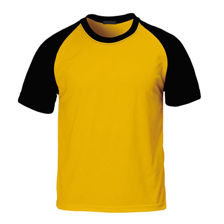

In [14]:
from PIL import Image
import io

img = Image.open(io.BytesIO(btn_upload.data[-1])).resize((224, 224))
img

##Generate Caption

In [20]:
image = preprocess(img).unsqueeze(0).to(device)
with torch.inference_mode():
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
generated_text_prefix = generate(model, tokenizer, embed=prefix_embed)

print('\n')
print(generated_text_prefix)

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]



a yellow t - shirt on a white background vector art illustration.
